# Intermediate Machine Learning: Assignment 2

**Deadline**

Assignment 2 is due Thursday, February 26 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Acknowledge any use of an AI system such as ChatGPT or Copilot.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas/Ed. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a .pdf on Gradescope. To convert your notebook to a .pdf while preserving the cell structure without truncating the output, you can convert to .html using [this notebook](https://colab.research.google.com/github/YData123/sds365-sp26/blob/main/assignments/Convert_ipynb_to_HTML_in_Colab.ipynb). Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

After downloading the .html file, open it and then select "File" and "Print" (note you will not actually be printing)
From the print window, select the option to save as a .pdf

**Topics**

 * Convolutional neural networks
 * Gaussian processes
 * Double descent

This assignment will also help to solidify your Python and Jupyter notebook skills.


## Problem 1: It's not a bug, it's a feature! (20 points)

In this problem, we will ["open the black box"](https://news.yale.edu/2018/12/10/why-take-ydata-because-data-science-shouldnt-be-black-box) and inspect the filters and feature maps learned by a convolutional neural network trained to classify handwritten digits, using the MNIST database.

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### 1.1 Visualizing the filters

To begin, we load the dataset with 60000 training images and 10000 test images.

In [2]:
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train_binary = keras.utils.to_categorical(y_train, num_classes)
y_test_binary = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Next, we initialize our convolutional neural network.

In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", name='conv1'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", name='conv2'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 8, 8, 32)       │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,594 (123.41 KB)

 Trainable params: 31,594 (123.41 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
batch_size = 128
epochs = 1

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train_binary, batch_size=batch_size, epochs=epochs, validation_split=0.1)

422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - accuracy: 0.7459 - loss: 0.7950 - val_accuracy: 0.9797 - val_loss: 0.0813


In [5]:
score = model.evaluate(x_test, y_test_binary, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0857885405421257
Test accuracy: 0.9743000268936157


Now that we've trained and tested the model, let's look at the filters learned in the first convolutional layer.

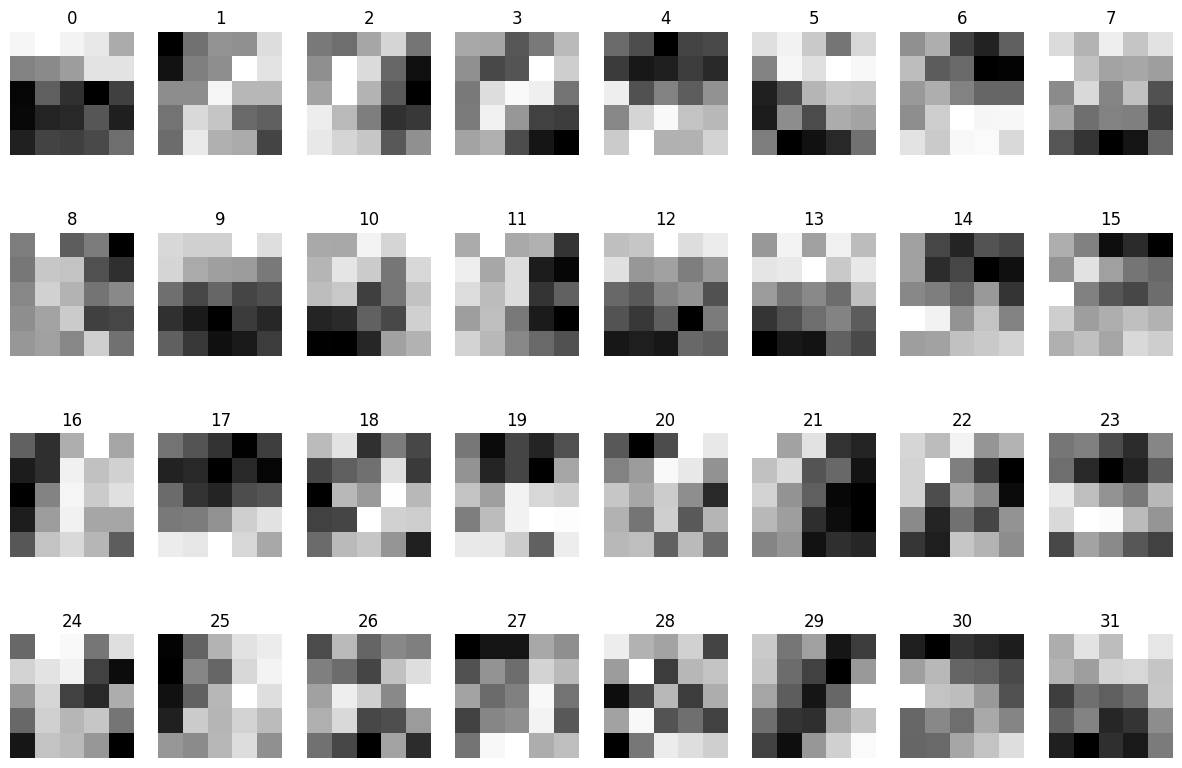

In [6]:
filters_conv1 = model.get_layer(name='conv1').get_weights()[0]

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

for i in range(4):
    for j in range(8):
        f = filters_conv1[:, :, 0, 8*i+j]
        axs[i, j].imshow(f[:, :], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(8*i+j)

1. Describe the function of each layer in your `model.summary()`. Can you figure out the number of parameters in each layer by yourself?

2. Describe what you observe. Do (some of) the learned filters make sense to you? You can pick one filter (e.g., filter 13) as an example.


Hint: Many filters have been designed and widely applied in image processing. [Here](http://www.theobjects.com/dragonfly/dfhelp/3-5/Content/05_Image%20Processing/Edge%20Detection%20Filters.htm) are some examples of edge detection filters and their effect on the image. You can find the details about each filter by clicking the links at the bottom.

**1.1** The layers of the model are the first convolutional layer, followed by a max pool, followed by another convolutional layer, then another max pool, then it's flattened, adjusted with some dropout, and then run through the fully connected layer. The first convolutional layer is learning basic features of the images, the max pool is reducing the dimensionality of the feature maps output by the previous layer, then the second convolutional layer is attempting to learn more complex features from those maps, then another pooling to reduce dimensions occurs, then the maps are flattened into a data vector which can be input into a fully connected layer, then dropout is applied to randomly mask certain inputs to increase generalizability and prevent overfitting, then the flattened output with dropout is run through a dense fully connected layer to make predictions. The number of parameters for each layer can be calculated as: conv1 = 5\*5\*32 + 32, maxpool has no parameters, conv2 = 5\*5\*32\*32 + 32, maxpool has no parameters, flatten has no params, dropout has no params, and the dense layer has 512\*10 + 10 parameters.

**1.2** I observe the different kernels learning different patterns that can potentially be used to identify numbers. For example, filter 4 is obviously a horizontal line, with white on the bottom and black on the top. This kind of pattern would be prevalent in many numbers and in many different places, so it makes sense to be learned as a filter.

In [ ]:
# Your Markdown Here

### 1.2 Visualizing the feature maps

We can also look at the corresponding feature map for each filter. There are 32 kernels at the first convolutional layer, so there are 32 feature maps for each sample. feature_map_conv1 is a 4D matrix where the first dimension is the index of the sample and the last dimension is the index of the correpsonding filter.

In [7]:
conv1_layer_model = keras.Model(inputs=model.inputs, outputs=model.get_layer('conv1').output)
feature_map_conv1 = conv1_layer_model(x_test)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(10000, 28, 28, 1))
  warnings.warn(msg)


Randomly draw 16 samples for visualization.

In [8]:
sample_index = random.sample(range(1, len(x_test)), 16)

Choose two filters among all 32 filters from 2.1, and visualize their feature maps.

In [9]:
filter_n1 = 4
filter_n2 = 21

There is no need to modify the next code cells, just run the four cells below.

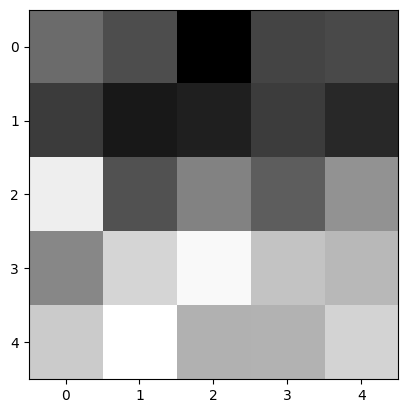

In [10]:
plt.imshow(filters_conv1[:, :, 0, filter_n1], cmap='gray')

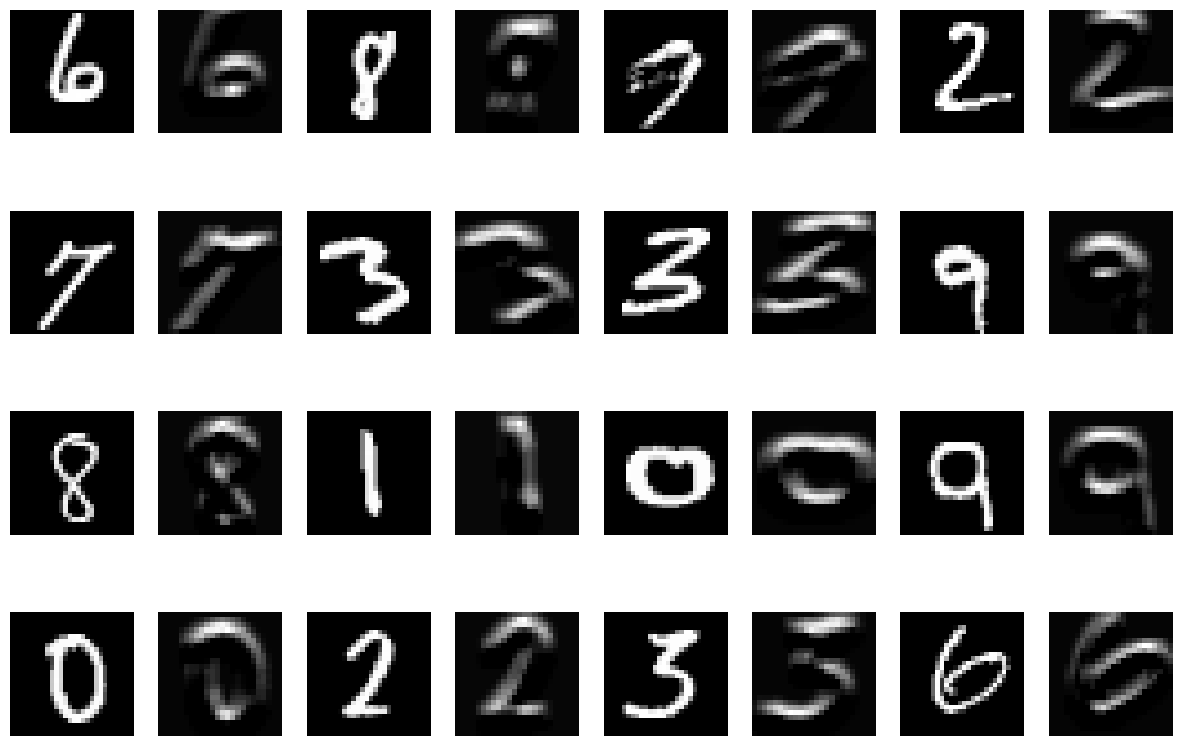

In [11]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv1[sample_index[4*i+j], :, :, filter_n1], cmap='gray')
        axs[i, 2*j+1].axis('off')

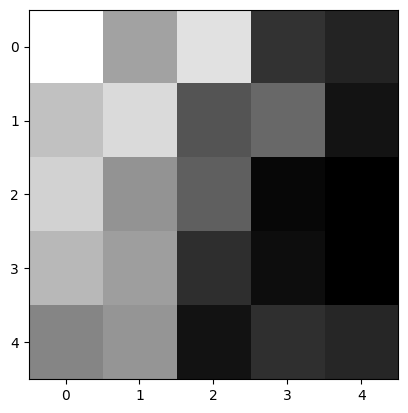

In [12]:
plt.imshow(filters_conv1[:, :, 0, filter_n2], cmap='gray')

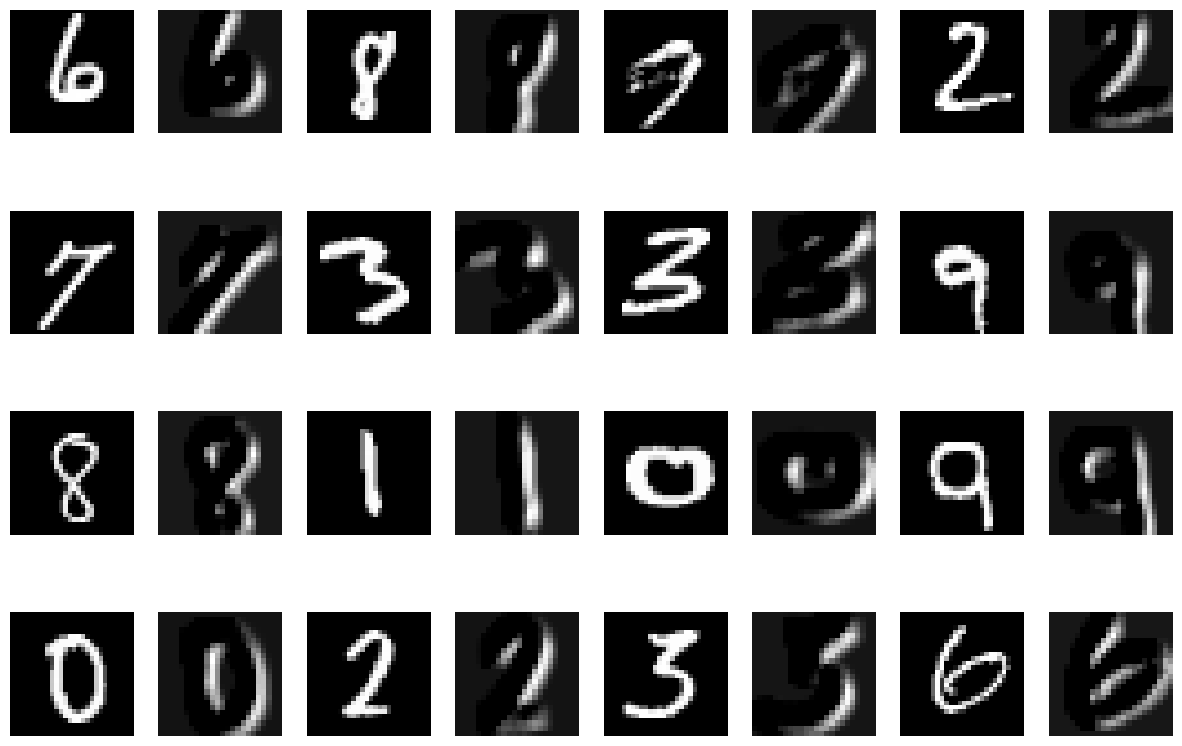

In [13]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv1[sample_index[4*i+j], :, :, filter_n2], cmap='gray')
        axs[i, 2*j+1].axis('off')

Comment on what you see in the feature maps.
* How do they correspond to the original images?
* How do they correspond to the filters?
* Why might the feature maps be helpful for classifying digits?

**1.2**

In the feature maps I see the original images, but only emphasized on the regions matching the orientation of the filter. I tried to choose a horizontal line filter (4) and a vertical line filter (21). The feature maps created reflect these, with kernel 4 creating feature maps with emphasis on the flat lines in the numbers and the the vertical lines with 21. These feature maps are useful for classifying digits because fundamentally all digits are a unique combination of vertical lines, horizontal lines, and curves so locating the approximate location and frequency of these features can help guess which digit it is.

In [ ]:
# Your markdown here

### 1.3 Fitting a logistic regression model on feature maps

The features of the images are further summarized after the second convolutional layer.

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(10000, 28, 28, 1))
  warnings.warn(msg)


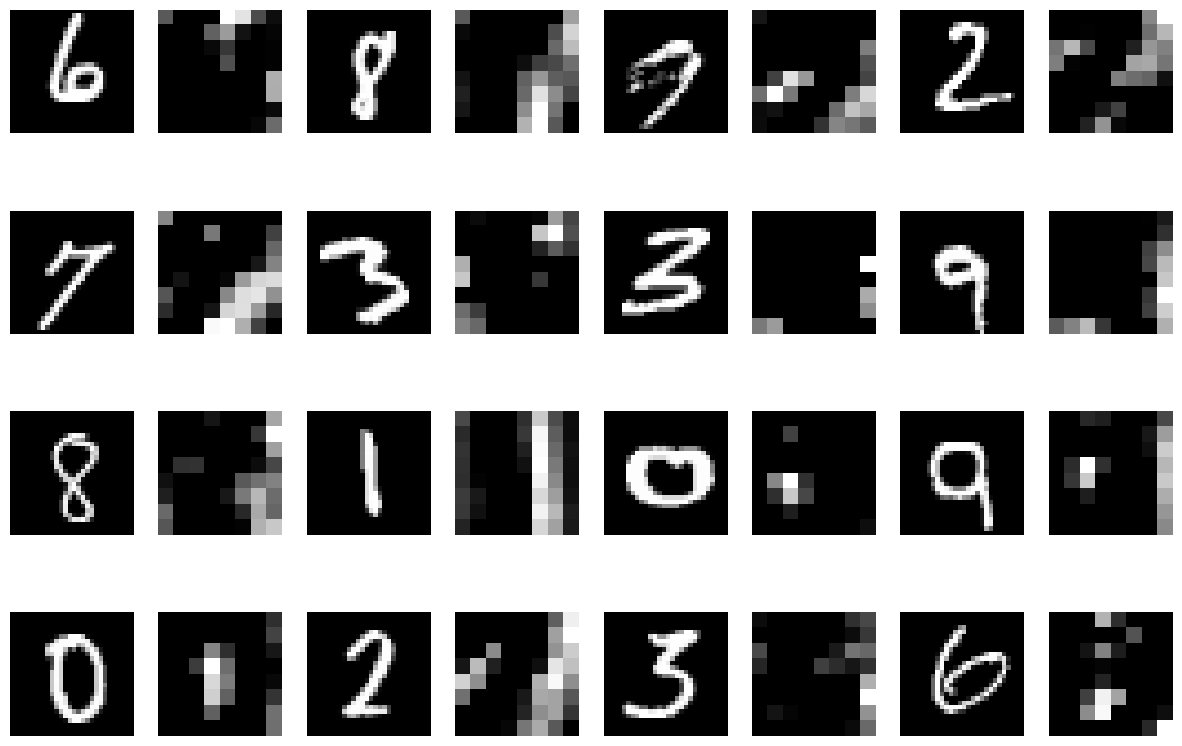

In [15]:
conv2_layer_model = keras.Model(inputs=model.inputs, outputs=model.get_layer('conv2').output)
feature_map_conv2 = conv2_layer_model(x_test)

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv2[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j+1].axis('off')

Build and test a logistic regression model to classify two digits of your choice (i.e. a binary classification) using the features maps at the second convolutional layer as the input. You may use logistic regression functions such as [LogisticRegression in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Use 80% of the data for training and 20% for test.

* How many features are there in your input X?

* How is your logistic regression model related to the fully connected layer and softmax layer in the convolutional neural network?

* What is the accuracy of your model? Is this expected, or surprising?

* Comment on any other aspects of your findings that are interesting to you.


In [16]:
X_lr = np.reshape(feature_map_conv2,(np.shape(feature_map_conv2)[0],-1))
y_lr = y_test

In [19]:
from sklearn.linear_model import LogisticRegression
# Your code here
digits = [6, 7]

train_mask = np.isin(y_train, digits)
test_mask = np.isin(y_test, digits)

x_train_bin = x_train[train_mask]
y_train_bin = y_train[train_mask]

x_test_bin = x_test[test_mask]
y_test_bin = y_test[test_mask]

y_train_bin = (y_train_bin == digits[1]).astype(int)
y_test_bin = (y_test_bin == digits[1]).astype(int)

train_features = conv2_layer_model(x_train_bin)
test_features = conv2_layer_model(x_test_bin)
X_train = train_features.numpy().reshape(train_features.shape[0], -1)
X_test = test_features.numpy().reshape(test_features.shape[0], -1)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train_bin, test_size=0.2, random_state=42
)


clf = LogisticRegression(max_iter=1000)
clf.fit(X_tr, y_tr)

print("Validation accuracy:", clf.score(X_val, y_val))
print("Test accuracy:", clf.score(X_test, y_test_bin))
print("Feature map shape:", train_features.shape)
print("Number of features:", X_train.shape[1])


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(12183, 28, 28, 1))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1986, 28, 28, 1))
  warnings.warn(msg)


Validation accuracy: 1.0
Test accuracy: 1.0
Feature map shape: (12183, 8, 8, 32)
Number of features: 2048


**1.3**

There are 2048 features in the input X. The logistic regression model is very similar to the dense layer + softmax because it creates a probabilistic prediction of the outputs by learning the features. The softmax creates a probability distribution over all outputs from the dense layer, whereas the logistic regression is a binary function only comparing two possible outputs. The model is 100% accurate, which isn't really surprising since 6 and 7 don't have a lot of features in common (6 being entirely curved and 7 being two straight lines), and prediction is a lot easier with only two outcomes. The only interesting idea of note is that when I changed it to 6 and 9, the accuracy was just below 100% (~.9996), which makes sense because these numbers are more similar and therefore harder to distinguish.

In [ ]:
# Your markdown here

## Problem 2: All that glitters (20 points)

In this problem you will use Gaussian process regression to model the trends in gold medal performances of selected events in the summer Olympics. The objectives of this problem are for you to:

* Gain experience with Gaussian processes, to better understand how they work
* Explore how posterior inference depends on the properties of the prior mean and kernel
* Use Bayesian inference to identify unusual events
* Practice making your Python code modular and reusable

For this problem, the only starter code we provide is to read in the data and extract
one event. You may write any GP code that you choose to, but please do not use any
package for Gaussian processes; your code should be "np-complete" (using only
basic `numpy` methods). You are encouraged to start from the [GP demo code](https://ydata123.org/fa24/interml/calendar.html) used in class.


When we ran the GP demo code from class on the marathon data, it generated the following plot:
<img src="https://github.com/YData123/sds365-fa22/raw/main/assignments/assn2/marathon.jpg" width="600">

Note several properties of this plot:
* It shows the Bayesian confidence of the regression, as a shaded area. This is a 95% confidence band because it has width given by $\pm 2 \sqrt{V}$, where $V$ is the estimated variance. The variance increases at the right side, for future years.

* The gold medal time for the 1904 marathon is outside of this confidence band. In fact, the 1904 marathon was an [unusual event](https://www.smithsonianmag.com/history/the-1904-olympic-marathon-may-have-been-the-strangest-ever-14910747/), and this is apparent from the model.

* The plot shows the posterior mean, and also shows one random sample from the posterior distribution.

Your task in this problem is generate such a plot for six different Olympic events by writing a function

`def gp_olympic_event(year, result, kernel, mean, noise, event_name):
    ...`
    
 where the input variables are the following:

* `year`: a numpy array of years (integers)
* `result`: a numpy array of numerical results, for the gold medal performances in that event
* `kernel`: a kernel function
* `mean`: a mean function
* `noise`: a single float for the variance of the noise, $\sigma^2$
* `event_name`: a string used to label the y-axis, for example "marathon min/mile (men's event)"

Your function should compute the Gaussian process regression, and then display the resulting plot, analogous to the plot above for the men's marathon event.

You will then process **six** of the events, three men's events and three women's events, and call your function to generate the corresponding six plots.

For each event, you should create a markdown cell that describes the resulting model. Comment on such things as:

* How you chose the kernel, mean, and noise.
* Why the plot does or doesn't look satisfactory to you
* If there are any events such as the 1904 marathon that are notable.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data

Use your best judgement to describe your findings; post questions to EdD if things are unclear. And have fun!



------------------

In the remainder of this problem description, we recall how we processed the marathon data, as an example. The following cell reads in the data and displays the collection of events that are included in the dataset.

In [2]:
import numpy as np
import pandas as pd

dat = pd.read_csv('https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/gaussian_processes/olympic_results.csv')
events = set(np.array(dat['Event']))
print(events)

{'Shot Put Women', '1500M Women', 'Pole Vault Men', 'Hammer Throw Women', 'Marathon Women', 'Hammer Throw Men', '100M Hurdles Women', 'Javelin Throw Men', '5000M Women', '4X100M Relay Men', 'Triple Jump Women', '1500M Men', 'Triple Jump Men', '5000M Men', '20Km Race Walk Men', 'Shot Put Men', '3000M Steeplechase Women', 'Javelin Throw Women', 'High Jump Men', 'Pole Vault Women', 'Heptathlon Women', '100M Women', '400M Women', '50Km Race Walk Men', '100M Men', 'High Jump Women', 'Long Jump Men', 'Long Jump Women', '800M Men', '110M Hurdles Men', '3000M Steeplechase Men', '4X100M Relay Women', '20Km Race Walk Women', '800M Women', 'Decathlon Men', '10000M Men', '4X400M Relay Men', '400M Hurdles Women', '200M Men', 'Discus Throw Men', '10000M Women', 'Marathon Men', 'Discus Throw Women', '400M Men', '4X400M Relay Women', '200M Women', '400M Hurdles Men'}


We then process the time to compute the minutes per mile (without checking that the race was actually 26.2 miles!)

In [3]:
marathon = dat[dat['Event'] == 'Marathon Men']
marathon = marathon[marathon['Medal']=='G']
marathon = marathon.sort_values('Year')
time = np.array(marathon['Result'])
mpm = []
for tm in time:
    t = np.array(tm.split(':'), dtype=float)
    minutes_per_mile = (t[0]*60*60 + t[1]*60 + t[2])/(60*26.2)
    mpm.append(minutes_per_mile)

marathon['Minutes per Mile'] = np.round(mpm,2)
marathon = marathon.drop(columns=['Gender', 'Event'], axis=1)
marathon.reset_index(drop=True, inplace=True)
year = np.array(marathon['Year'])
result = np.array(marathon['Minutes per Mile'])
marathon

,Location,Year,Medal,Name,Nationality,Result,Minutes per Mile
0,Athens,1896,G,Spyridon LOUIS,GRE,2:58:50,6.83
1,Paris,1900,G,Michel THÃATO,FRA,2:59:45.0,6.86
2,St Louis,1904,G,Thomas HICKS,USA,3:28:53.0,7.97
3,London,1908,G,John HAYES,USA,2:55:18.4,6.69
4,Stockholm,1912,G,Kennedy Kane MCARTHUR,RSA,2:36:54.8,5.99
5,Antwerp,1920,G,Hannes KOLEHMAINEN,FIN,2:32:35.8,5.82
6,Paris,1924,G,Albin STENROOS,FIN,2:41:22.6,6.16
7,Amsterdam,1928,G,BoughÃ¨ra EL OUAFI,FRA,2:32:57,5.84
8,Los Angeles,1932,G,Juan Carlos ZABALA,ARG,2:31:36,5.79
9,Berlin,1936,G,Kitei SON,JPN,2:29:19.2,5.70


Enter your code and markdown following this cell.

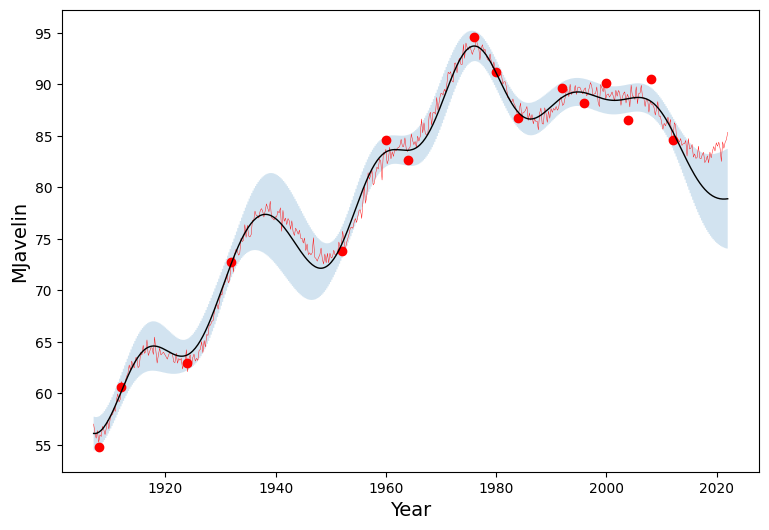

In [5]:
from numpy.linalg import cholesky

def gaussian_sample(mu, Sigma):
    A = cholesky(Sigma)
    Z = np.random.normal(loc=0, scale=1, size=len(mu))
    return np.dot(A, Z) + mu

def mu_fun(x, mu=0):
    return mu * np.ones(len(x))

def K_fun(x, z, h=1):
    K = np.zeros(len(x)*len(z)).reshape(len(x), len(z))
    for j in np.arange(K.shape[1]):
        K[:,j] = h*np.exp(-(x-z[j])**2/(2*h**2))
    return K

javelin = dat[dat['Event'] == 'Javelin Throw Men']
javelin = javelin[javelin['Medal'] == 'G']
javelin = javelin.sort_values('Year')

result_j = np.array(javelin['Result'], dtype=float)
year_j = np.array(javelin['Year'], dtype=float)

mask = ~np.isnan(result_j)
result_j = result_j[mask]
year_j = year_j[mask]

def gp_olympic_event(year, result, kernel, mean, noise, event_name, h=7):
    Xtrain = year
    ytrain = result
    xs = np.linspace(np.min(year)-1,
                     np.max(year)+10,
                     500)

    K = kernel(Xtrain, Xtrain, h=h)
    Ks = kernel(Xtrain, xs, h=h)
    Kss = kernel(xs, xs, h=h) + noise * np.eye(len(xs))

    Ky = K + noise * np.eye(len(Xtrain))
    Ki = np.linalg.inv(Ky)

    postMu  = mean(xs) + Ks.T @ Ki @ (ytrain - mean(Xtrain))
    postCov = Kss - Ks.T @ Ki @ Ks

    ys = gaussian_sample(postMu, postCov)
    S2 = np.diag(postCov)

    fig, ax = plt.subplots(1,1,figsize=(9,6))

    ax.fill_between(xs, postMu - 2*np.sqrt(S2), postMu + 2*np.sqrt(S2),
                      step="pre", alpha=0.2, label='posterior 95% confidence')

    ax.plot(xs, ys, c='r', linewidth=.3)
    ax.plot(xs, postMu, c='black', linewidth=1)
    ax.scatter(year, result, color='red')

    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(event_name, fontsize=14)
    plt.show()


gp_olympic_event(
    year=year_j,
    result=result_j,
    kernel=K_fun,
    mean=lambda x: mu_fun(x, np.mean(result_j)),
    noise=0.3,
    event_name="MJavelin",
    h=7
)


**Men's Javelin Throw**

I simply chose the kernel from the demo code. I had to adjust the scale factor that was initially set to 1/h, and I set it to h instead. I made this decision because the error bars weren't visible or scaled correctly for the javelin data, as the demo code was for marathons. The mean is simply the average of all men's javelin toss gold medal distances, and noise was also arbitrarily chosen to scale with the task of javelin toss. There is a data gap during World War 2, and the confidence interval expands a lot around that area as such. The plot is overall not satisfactory to me as the future predictions it makes are very low and have an odd trend. The data indicates it should just stay level or fluctuate, not plummet.

[1932. 1936. 1948. 1952. 1960. 1964. 1968. 1972. 1976. 1980. 1992. 1996.
 2000. 2004. 2008. 2012. 2016.]


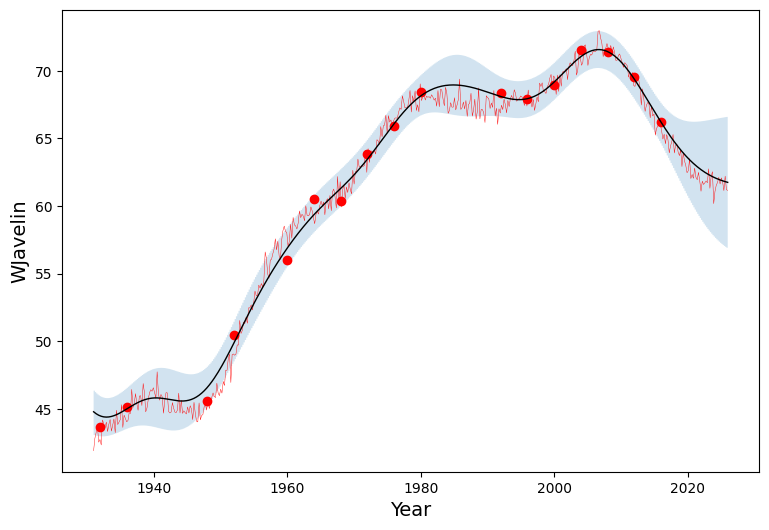

In [6]:
wjavelin = dat[dat['Event'] == 'Javelin Throw Women']
wjavelin = wjavelin[wjavelin['Medal'] == 'G']
wjavelin = wjavelin.sort_values('Year')

result_wj = np.array(wjavelin['Result'], dtype=float)
year_wj = np.array(wjavelin['Year'], dtype=float)

print(year_wj)

mask = ~np.isnan(result_wj)
result_wj = result_wj[mask]
year_wj = year_wj[mask]

gp_olympic_event(
    year=year_wj,
    result=result_wj,
    kernel=K_fun,
    mean= lambda x: mu_fun(x, np.mean(result_wj)),
    noise=0.3,
    event_name="WJavelin",
    h=7
)

**Women's Javelin Throw**

I simply chose the kernel from the demo code. I had to adjust the scale factor that was initially set to 1/h, and I set it to h instead. I made this decision because the error bars weren't visible or scaled correctly for the javelin data, as the demo code was for marathons. The mean is simply the average of all women's javelin gold medal distances, and noise was also arbitrarily chosen to scale with the task of javelin toss. There is a data gap during World War 2, and the confidence interval expands a lot around that area as such. The women's plot, much like the mens, is unsatisfactory in the sense that it predicts a decrease in javelin toss distances. However this prediction seems in line with the data as for some reason the throws have fallen off in recent years.

[2000. 2004. 2008. 2016.]


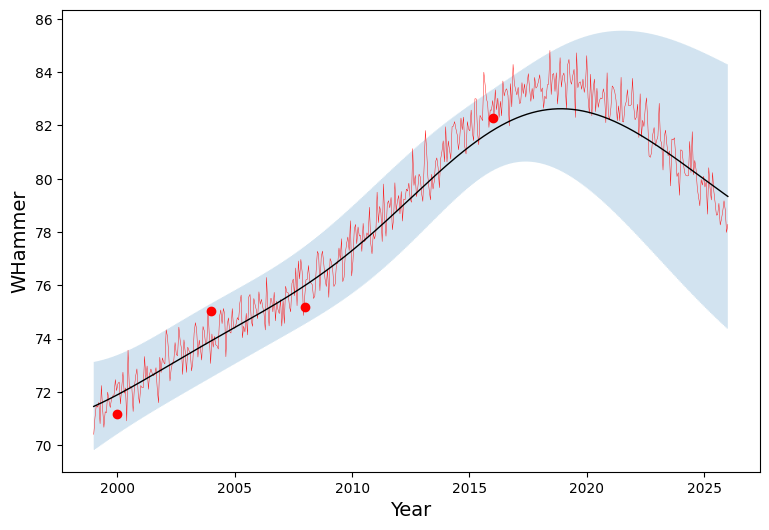

In [81]:
whammer = dat[dat['Event'] == 'Hammer Throw Women']
whammer = whammer[whammer['Medal'] == 'G']
whammer = whammer.sort_values('Year')

result_wh = np.array(whammer['Result'], dtype=float)
year_wh = np.array(whammer['Year'], dtype=float)

print(year_wh)

mask = ~np.isnan(result_wh)
result_wh = result_wh[mask]
year_wh = year_wh[mask]

gp_olympic_event(
    year=year_wh,
    result=result_wh,
    kernel=K_fun,
    mean= lambda x: mu_fun(x, np.mean(result_wh)),
    noise=0.3,
    event_name="WHammer",
    h=7
)

**Women's Hammer Throw**

I chose the kernel from the demo code. I adjusted the scale factor for the kernel which was initially set to 1/h to h instead. I made this decision because the error bars weren't visible or scaled correctly for the hammer data, as the demo code was for marathons. The mean is simply the average of all women's hammer throw gold medal distances, and noise was also arbitrarily chosen to scale with the task of hammer throw. This event has not existed for very long and as such there is not a significant amount of damage. That said, the plot is unsatisfactory as there's not ample data to establisg a trend. It also once again predicts a falling off when the trend has previously been increasing.

[1900. 1904. 1908. 1912. 1924. 1932. 1952. 1960. 1964. 1976. 1980. 1992.
 1996. 2000. 2004. 2008. 2012. 2016.]


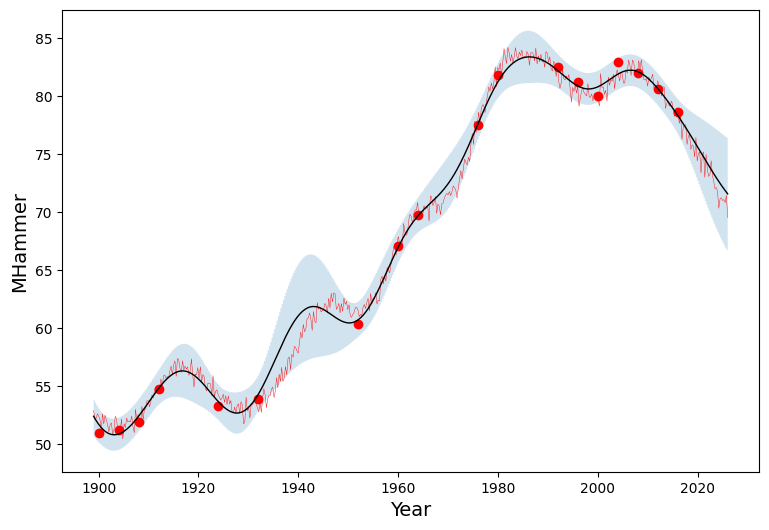

In [82]:
hammer = dat[dat['Event'] == 'Hammer Throw Men']
hammer = hammer[hammer['Medal'] == 'G']
hammer = hammer.sort_values('Year')

result_h = np.array(hammer['Result'], dtype=float)
year_h = np.array(hammer['Year'], dtype=float)

print(year_h)

mask = ~np.isnan(result_h)
result_h = result_h[mask]
year_h = year_h[mask]

gp_olympic_event(
    year=year_h,
    result=result_h,
    kernel=K_fun,
    mean= lambda x: mu_fun(x, np.mean(result_h)),
    noise=0.3,
    event_name="MHammer",
    h=7
)

**Men's Hammer Throw**

I chose the kernel from the demo code. I adjusted the scale factor for the kernel which was initially set to 1/h to h instead. I made this decision because the error bars weren't visible or scaled correctly for the hammer data, as the demo code was for marathons. The mean is simply the average of all men's hammer throw gold medal distances, and noise was also arbitrarily chosen to scale with the task of hammer throw. The men's hammer throw has been around much longer than the women's, and as such we see data gaps around both world wars, with the common trend of confidence intervals expanding aroung those areas. Once again I'm not entirely satisfied with the predictions is makes, but once again the data supports them as there is a decreasing trend in the distances over the past 20 or so years.

[1896. 1904. 1908. 1912. 1924. 1932. 1952. 1960. 1964. 1968. 1976. 1980.
 1984. 1992. 1996. 2000. 2004. 2008. 2012. 2016.]


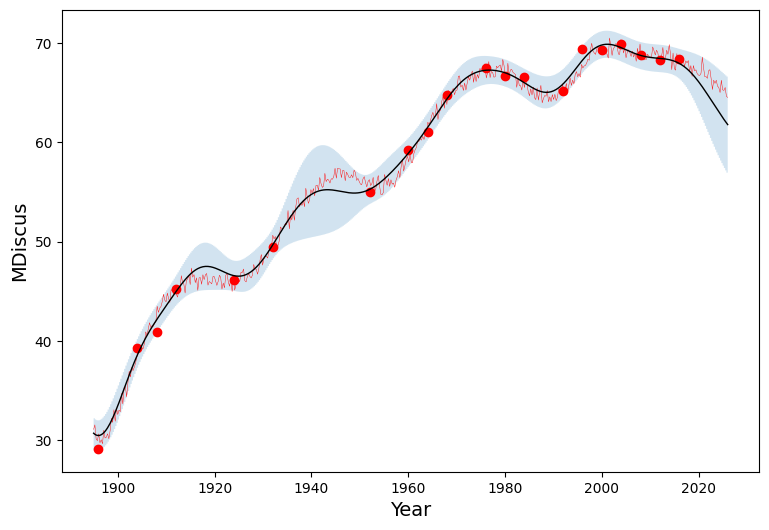

In [83]:
discus = dat[dat['Event'] == 'Discus Throw Men']
discus = discus[discus['Medal'] == 'G']
discus = discus.sort_values('Year')

result_d = np.array(discus['Result'], dtype=float)
year_d = np.array(discus['Year'], dtype=float)

print(year_d)

mask = ~np.isnan(result_d)
result_d = result_d[mask]
year_d = year_d[mask]

gp_olympic_event(
    year=year_d,
    result=result_d,
    kernel=K_fun,
    mean= lambda x: mu_fun(x, np.mean(result_d)),
    noise=0.3,
    event_name="MDiscus",
    h=7
)

**Men's Discus**

I chose the kernel from the demo code. I adjusted the scale factor for the kernel which was initially set to 1/h to h instead. I made this decision because the error bars weren't visible or scaled correctly for the discus data, as the demo code was for marathons. The mean is simply the average of all men's discus gold medal distances, and noise was also arbitrarily chosen to scale with the task of discus. There's once again data gaps around the two world wars with increased confidence intervals accordingly. The predictions are once again in line with current trends, so I would call it somewhat satisfactory.

[1928. 1932. 1936. 1948. 1952. 1960. 1964. 1968. 1972. 1980. 1984. 1992.
 1996. 2000. 2004. 2008. 2012. 2016.]


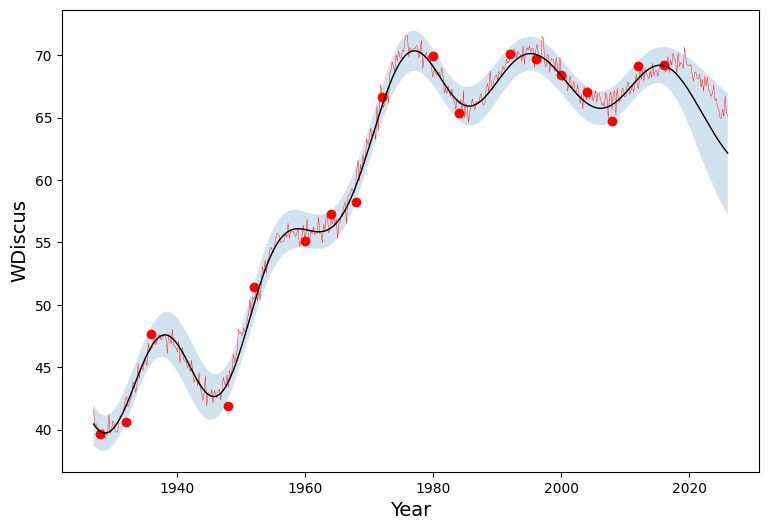

In [84]:
wdiscus = dat[dat['Event'] == 'Discus Throw Women']
wdiscus = wdiscus[wdiscus['Medal'] == 'G']
wdiscus = wdiscus.sort_values('Year')

result_wd = np.array(wdiscus['Result'], dtype=float)
year_wd = np.array(wdiscus['Year'], dtype=float)

print(year_wd)

mask = ~np.isnan(result_wd)
result_wd = result_wd[mask]
year_wd = year_wd[mask]

gp_olympic_event(
    year=year_wd,
    result=result_wd,
    kernel=K_fun,
    mean= lambda x: mu_fun(x, np.mean(result_wd)),
    noise=0.3,
    event_name="WDiscus",
    h=7
)

**Women's Discus**

I chose the kernel from the demo code. I adjusted the scale factor for the kernel which was initially set to 1/h to h instead. I made this decision because the error bars weren't visible or scaled correctly for the discus data, as the demo code was for marathons. The mean is simply the average of all wommen's discus gold medal distances, and noise was also arbitrarily chosen to scale with the task of discus. The event started post world war 1, but there;s still the gap during world war 2, but interestingly the confidence interval was not too shaken by this. Other than that I find the predictions a little too wiggly, the fit is a little too snug, causing predictions to taper down at the end when they perhaps shouldn't.

## Problem 3: Double descent! (20 points)

<a href="https://skitheworld.com/2018/12/wurtele-twins-appointed-order-canada/"><img src="https://raw.githubusercontent.com/YData123/sds365-fa22/main/assignments/assn1/double.jpg" width="200" align="left" style="margin:10px 30px 10px 0px"></a>


In this problem you will explore the "double descent" phenomenon that was recently
discovered as a key principle underlying the performance of deep neural networks.
The problem setup is a "random features" version of a 2-layer neural network. The weights in the first layer are random and fixed, and the weights in the second layer are estimated from data. As we increase the number of neurons in the hidden layer, the dimension $p$ of model increases. It's helpful to define the ratio $\gamma = p/n$ of variables to sample points. If $\gamma < 1$ then we want to use the OLS estimator, and if $\gamma > 1$ we want to use the minimum norm estimator.
<br>

Your mission (should you choose to accept it), is

1. Implement a function `OLS_or_minimum_norm` that computes the least squares solution when $\gamma < 1$, and the minimum norm solution when $\gamma > 1$. (When $\gamma=1$ the estimator does not, in general, exist.)
1. Run the main code we give you to average over many trials, and to compute and plot the estimated risk for a range of values of $\gamma$.
1. Next, extend the starter code so that you compute (estimates of) the squared-bias and variance of the models. To do this, note that you'll need access to the true regression function, which is provided. You may want to refer to the demo code for smoothing kernels as an example.
1. Using your new code, extend the plotting function we provide so that you plot
the squared-bias, variance, and risk together on the same plot.
1. Finally, comment on the results, describing why it might make sense that the squared bias, variance, and risk have the given shapes that they do.
1. Show that in the overparameterized regime $\gamma > 1$, as $\lambda \to 0$, the ridge regression estimator converges to the minimum norm estimator.


By doing this exercise you will solidify your understanding of the meaning of bias and variance, and also gain a better understanding of the "double descent" phenomenon for overparameterized neural networks,
and their striking resistance to overfitting.

We're available in OH to help with any issues you run into!

If you have any interest in background reading on this topic (not expected or required), we recommend Hastie et al., ["Surprises in high-dimensional ridgeless least squares regression"](https://www.stat.cmu.edu/~ryantibs/papers/ridgeless.pdf).



In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### Problem 3.1

Implement the function `OLS_or_minimum_norm` that computes the OLS solution for $\gamma < 1$, and the minimum norm solution for $\gamma > 1$.

In [8]:
def OLS_or_minimum_norm(X, y):
    ## Your code here
    n, p = X.shape
    gamma = p / n

    if gamma < 1:
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
    elif gamma > 1:
        XXT = X @ X.T
        beta = X.T @ np.linalg.solve(XXT, y)

    return beta

In [9]:
# A plotting function we provide. No need to change this, although you can if you'd like.

def plot_double_descent_risk(gammas, risk, sigma):
    gammas = np.round(gammas, 2)
    fig, ax = plt.subplots(figsize=(10,6))
    tick_pos = np.zeros(len(gammas))
    for i in np.arange(len(gammas)):
        if gammas[i] <= 1:
            tick_pos[i] = gammas[i] * 10
        else:
            tick_pos[i] = gammas[i] + 9
    ax.axvline(x=tick_pos[np.array(gammas)==1][0], linestyle='dashed', color='gray')
    ax.axhline(y=sigma**2, linestyle='dashed', color='gray')
    ax.scatter(tick_pos, risk, color='salmon')
    ax.plot(tick_pos, risk, color='gray', linewidth=.5)

    tickgam = [gam for gam in gammas if (gam > .05 and gam <= .9) or gam >= 2 or gam == 1]
    ticks = [tick_pos[j] for j in np.arange(len(tick_pos)) if gammas[j] in tickgam]
    ax.xaxis.set_ticks(ticks)
    ax.xaxis.set_ticklabels(tickgam)

    plt.xlabel(r'$\gamma = \frac{p}{n}$', fontsize=18)
    _ = plt.ylabel('Risk', fontsize=18)

### Data setup

The following cell sets up our data. The inputs $X$ are
random Gaussian vectors of dimension $d=10$. Then, we map these
using a neural network with fixed, Gaussian weights, to get random features
corresponding to $p^* = 150$ hidden neurons. The second layer
coefficients are $\beta^* \in {\mathbb R}^{p^*}$, which are fixed.
This defines the true model.


In [10]:
# just execute this cell, after you define the function above.

np.random.seed(123456)

sigma = 1
d = 10
p_star = 150
signal_size = 5

W_star = (1/np.sqrt(d)) * np.random.randn(d, p_star)
beta_star = np.arange(p_star)
beta_star = signal_size * beta_star / np.sqrt(np.sum(beta_star**2))

N = 10000
X = np.random.randn(N, d)

# f_star is the true regression function, for computing the squared bias
f_star = np.dot(np.tanh(np.dot(X, W_star)), beta_star)
noise = sigma * np.random.randn(N)
y = f_star + noise
yf = np.concatenate((y.reshape(N,1), f_star.reshape(N,1)), axis=1)

### Train a sequence of models for different values of $\gamma$

Next, we train a sequence of models for different values of $\gamma$, always
fixing the sample size at $n=200$, but varying the dimension $p = \gamma n$.
When $p < p^*$ we just take the first $p$ features in the true model.
When $p > p^*$ we add $p-p^*$ neurons to the hidden layer, with their
own random weights.

In the code below, we loop over the different values of $\gamma$,
and for each $\gamma$ we run $100$ trials, each time generating
a new training set of size $n=200$. The model (either OLS or minimum norm) is then computed, the MSE is computed, and finally the risk is estimated by averaging over all $100$ trials.


In [11]:
trials = 100
n = 200

gammas = list(np.arange(.1, 1, .1)) + [.92, .94, 1, 1.1, 1.2, 1.4, 1.6] + list(np.arange(2, 11, 1))
gammas = [.01, .05] + gammas
risk = []

estimates = []

for gamma in gammas:
    err = []
    p = int(n * gamma)
    estimates_gamma = []
    if gamma == 1:
        risk.append(np.inf)
        estimates.append(None)
        continue
    W = (1/np.sqrt(d)) * np.random.randn(d, p)
    W[:,:min(p, p_star)] = W_star[:,:min(p, p_star)]
    for i in np.arange(trials):
        X_train, X_test, yf_train, yf_test = train_test_split(X, yf, train_size=n, test_size=1000)
        H_train = np.tanh(np.dot(X_train, W))
        H_test = np.tanh(np.dot(X_test, W))
        beta_hat = OLS_or_minimum_norm(H_train, yf_train[:,0])
        yhat_test = H_test @ beta_hat
        err.append(np.mean((yhat_test - yf_test[:,0])**2))
        estimates_gamma.append(yhat_test)

    estimates.append(estimates_gamma)
    print('gamma=%.2f  p=%d  n=%d  risk=%.3f' % (gamma, p, n, np.mean(err)))
    risk.append(np.mean(err))


gamma=0.01  p=2  n=200  risk=7.373
gamma=0.05  p=10  n=200  risk=4.146
gamma=0.10  p=20  n=200  risk=2.294
gamma=0.20  p=40  n=200  risk=2.099
gamma=0.30  p=60  n=200  risk=2.267
gamma=0.40  p=80  n=200  risk=2.534
gamma=0.50  p=100  n=200  risk=3.011
gamma=0.60  p=120  n=200  risk=3.573
gamma=0.70  p=140  n=200  risk=4.443
gamma=0.80  p=160  n=200  risk=6.885
gamma=0.90  p=180  n=200  risk=15.773
gamma=0.92  p=184  n=200  risk=20.500
gamma=0.94  p=188  n=200  risk=31.661
gamma=1.10  p=220  n=200  risk=24.179
gamma=1.20  p=240  n=200  risk=14.097
gamma=1.40  p=280  n=200  risk=8.089
gamma=1.60  p=320  n=200  risk=6.543
gamma=2.00  p=400  n=200  risk=5.301
gamma=3.00  p=600  n=200  risk=4.073
gamma=4.00  p=800  n=200  risk=3.658
gamma=5.00  p=1000  n=200  risk=3.430
gamma=6.00  p=1200  n=200  risk=3.309
gamma=7.00  p=1400  n=200  risk=3.135
gamma=8.00  p=1600  n=200  risk=3.190
gamma=9.00  p=1800  n=200  risk=3.056
gamma=10.00  p=2000  n=200  risk=3.062


### Plot the risk

At this point, you can plot the risk by just evaluating the cell below.
This should reveal the "double descent" behavior.


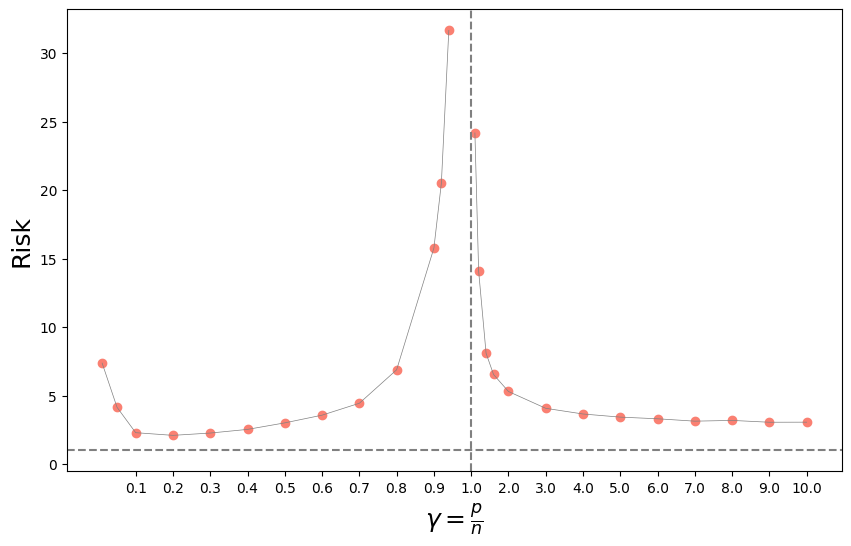

In [12]:
# Just evaluate the next line
plot_double_descent_risk(gammas, risk, sigma)

### Problem 3.2

Comment on the results. Explain why the risk plot does or does not make sense
in each regime: The underparameterized regime $\gamma < 1$, and the overparameterized
regime $\gamma > 1$. Is the curve "U-shaped" in the underparameterized regime? Why or why not?
What about in the overparameterized regime? You will be able to give better answers to these questions when you estimate the bias and variance below.


**3.2**

When the model is underparameterized, the risk follows the classical U shape, with very few parameters the model is too simple and has high bias, then as you add parameters it fits the signal better and test error drops, and as you approach, variance grows and test error rises again because the model becomes sensitive to noise. In the overparameterized regime, the model has more than enough parameters to perfectly fit the training data. As you add even more parameters, the model doesn't necessarily overfit worse, it can just fit the data in more ways. This causes the displayed dropping off of risk back to what we saw in the bottom of the U in the underparameterized regime.

[Your markdown here]

### Problem 3.3

Now, modify the above code so that you can estimate both the squared bias and the
variance of the estimator. Before you do this, you may want to revisit the kernel smoothing demo from class, where we computed the squared bias, variance, and risk. You'll need the true function, which is provided in the variable `yf`.  You should not have to write a lot of code, but can compute the bias and variance after you store the predicted values on the test data for each trial.

Plot the results, by plotting both the squared bias, the variance, and the risk for the sequence of gammas. To do this you will have to modify the plotting function appropriately, but this again involves minimal changes. When you obtain your final plot, comment
on the shape of the bias and variance curves, as above for Problem 3.2.


gamma=0.01  p=2  n=200  risk=7.647
gamma=0.05  p=10  n=200  risk=4.332
gamma=0.10  p=20  n=200  risk=2.163
gamma=0.20  p=40  n=200  risk=2.043
gamma=0.30  p=60  n=200  risk=2.158
gamma=0.40  p=80  n=200  risk=2.467
gamma=0.50  p=100  n=200  risk=2.878
gamma=0.60  p=120  n=200  risk=3.430
gamma=0.70  p=140  n=200  risk=4.452
gamma=0.80  p=160  n=200  risk=6.755
gamma=0.90  p=180  n=200  risk=16.012
gamma=0.92  p=184  n=200  risk=21.620
gamma=0.94  p=188  n=200  risk=29.002
gamma=1.10  p=220  n=200  risk=24.308
gamma=1.20  p=240  n=200  risk=13.368
gamma=1.40  p=280  n=200  risk=7.599
gamma=1.60  p=320  n=200  risk=6.597
gamma=2.00  p=400  n=200  risk=5.229
gamma=3.00  p=600  n=200  risk=3.916
gamma=4.00  p=800  n=200  risk=3.584
gamma=5.00  p=1000  n=200  risk=3.301
gamma=6.00  p=1200  n=200  risk=3.210
gamma=7.00  p=1400  n=200  risk=3.103
gamma=8.00  p=1600  n=200  risk=3.004
gamma=9.00  p=1800  n=200  risk=3.040
gamma=10.00  p=2000  n=200  risk=2.963


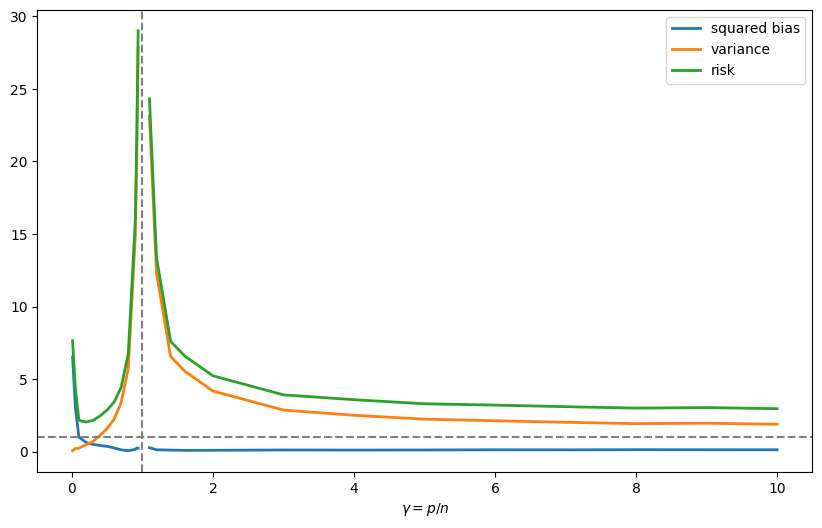

In [13]:
X_test = X[:1000]                 # fixed test set instead of resampling each trial
yf_test = yf[:1000]
f_test = yf_test[:,1]             # needed for bias calculation

risk = []
sq_bias = []
variance = []
estimates = []

for gamma in gammas:
    err = []
    p = int(n * gamma)
    estimates_gamma = []

    if gamma == 1:
        risk.append(np.inf)
        sq_bias.append(np.inf)
        variance.append(np.inf)
        estimates.append(None)
        continue

    W = (1/np.sqrt(d)) * np.random.randn(d, p)
    W[:,:min(p, p_star)] = W_star[:,:min(p, p_star)]

    for i in np.arange(trials):

        X_train, _, yf_train, _ = train_test_split(
            X, yf, train_size=n
        )                         # ignores test output because test set is fixed above

        H_train = np.tanh(np.dot(X_train, W))
        H_test = np.tanh(np.dot(X_test, W))   # uses fixed X_test instead of split X_test

        beta_hat = OLS_or_minimum_norm(H_train, yf_train[:,0])

        yhat_test = H_test @ beta_hat

        err.append(np.mean((yhat_test - yf_test[:,0])**2))  # uses fixed yf_test
        estimates_gamma.append(yhat_test)

    estimates_gamma = np.array(estimates_gamma)   # needed for bias/variance computation
    estimates.append(estimates_gamma)

    mean_pred = np.mean(estimates_gamma, axis=0)
    sq_bias_gamma = np.mean((mean_pred - f_test)**2)
    var_gamma = np.mean(np.var(estimates_gamma, axis=0))
    risk_gamma = np.mean(err)

    sq_bias.append(sq_bias_gamma)
    variance.append(var_gamma)
    risk.append(risk_gamma)

    print('gamma=%.2f  p=%d  n=%d  risk=%.3f' %
          (gamma, p, n, risk_gamma))

plt.figure(figsize=(10,6))
plt.plot(gammas, sq_bias, label='squared bias', linewidth=2)
plt.plot(gammas, variance, label='variance', linewidth=2)
plt.plot(gammas, risk, label='risk', linewidth=2)
plt.axvline(1, linestyle='dashed', color='gray')
plt.axhline(sigma**2, linestyle='dashed', color='gray')
plt.xlabel(r'$\gamma = p/n$')
plt.legend()
plt.show()

In [15]:
# Your code and markdown here.

**3.3**

Building on my earlier explanation of the U shape and the drop in risk after interpolation, the bias and variance curves clarify why that happens. In the underparameterized regime, the bias is high at first because the model is too simple, and it steadily decreases as we add parameters. At the same time, variance increases as we approach the 1 threshold, which is what causes the right side of that U and the spike in risk near 1. In the overparameterized regime, as I mentioned, the model can fit the data in many different ways. As such the bias remains low, and variance, after peaking near p/n = 1, begins to decrease again as the model becomes more overparameterized. That reduction in variance is what explains the “dropping off of risk” I referred to in my original response.

### Problem 3.4

In class, we discussed the interpretation of the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $. Geometrically, we can describe $ \hat{\beta}_{\text{mn}} $ as the orthogonal projection of the zero vector in $ \mathbb{R}^p $ onto the $ (p-1) $-dimensional hyperplane $ \{ \beta : X\beta = Y \} $.  

This can also be viewed as "ridgeless" regression. In ridge regression, we minimize the objective function
$$
\| Y - X\beta  \|_2^2 + \lambda \| \beta \|_2^2,
$$
which has the closed-form solution
$$
\hat{\beta}_{\lambda} = (X^T X + \lambda I)^{-1} X^T Y.
$$

In the overparameterized regime where $ p > n $, it can be shown that as $ \lambda \to 0 $, $ \hat{\beta}_{\lambda} $ converges to $ \hat{\beta}_{\text{mn}} $.

Your task is to show that as $ \lambda \to 0 $, the limit of the ridge regression estimator $ \hat{\beta}_{\lambda} $, in the overparameterized regime where $ \gamma > 1 $, is the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $. You may want to use the Woodbury formula for this derivation.


_Hint_:
1. Applying the simplified version of Woodbury formula
$$
(I + UV^T)^{-1} = I - U(I + V^T U)^{-1} V^T.
$$
we can derive the identity:
$$
(X^T X + \lambda I_p)^{-1} X^T = X^T (X X^T + \lambda I_n)^{-1},
$$
2. You might consider using the Woodbury formula twice.



[Your markdown here]